In [1]:
import gc
import random

from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, auc

import h5py
from concurrent.futures import ThreadPoolExecutor

import cv2
import numpy as np
import pandas as pd
import pydicom as dicom
from keras import Model, Input
from keras.src.layers import Dense, Dropout
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.src.callbacks import Callback
from sklearn.metrics import roc_curve, auc, roc_auc_score
from tensorflow.python.framework import constant_op
from tensorflow.python.ops import clip_ops, math_ops
from tensorflow.keras import backend as K
from keras.src import ops
from tqdm import tqdm

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


2024-08-07 23:42:37.401810: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-08-07 23:42:37.401852: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-08-07 23:42:37.401863: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-08-07 23:42:37.401900: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-08-07 23:42:37.401922: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### ファイル名の定義

In [3]:
train_image_hdf5 = "train-image.hdf5"
train_metadata_csv = "train-metadata.csv"
test_image_hdf5 = "test-image.hdf5"
test_metadata_csv = "test-metadata.csv"
sample_submission_csv = "sample_submission.csv"

base_path = "/Users/toru/PycharmProjects/isic-2024-challenge"

### パラメータの定義

In [4]:
CONFIG = {
    "SEED": 42,
    "N_FOLDS": 5,
    "N_EPOCHS": 100,
    "BATCH_SIZE": 32,
    "VAL_BATCH_SIZE": 32,
    "LR": 0.001,
    "IMAGE_HEIGHT": 224,
    "IMAGE_WIDTH": 224,
    "IMAGE_CHANNEL": 3,
    "N_CLASSES": 1,
    "PATIENCE": 10,
    "TRAIN_RATIO": 0.9,
    "VAL_RATIO": 0.05,
    "TEST_RATIO": 0.05,
}

In [5]:
df_train = pd.read_csv(f"{base_path}/{train_metadata_csv}")
df_test = pd.read_csv(f"{base_path}/{test_metadata_csv}")

/var/folders/1j/s9068l9s3pl56py3mj3r1wkh0000gn/T/ipykernel_8355/1119585719.py:1: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv(f"{base_path}/{train_metadata_csv}")


In [6]:
df_train

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401054,ISIC_9999937,0,IP_1140263,70.0,male,anterior torso,6.80,TBP tile: close-up,3D: XP,22.574335,...,IL_9520694,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999988
401055,ISIC_9999951,0,IP_5678181,60.0,male,posterior torso,3.11,TBP tile: close-up,3D: white,19.977640,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999820
401056,ISIC_9999960,0,IP_0076153,65.0,female,anterior torso,2.05,TBP tile: close-up,3D: XP,17.332567,...,IL_9852274,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999416
401057,ISIC_9999964,0,IP_5231513,30.0,female,anterior torso,2.80,TBP tile: close-up,3D: XP,22.288570,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,100.000000


In [7]:
def get_image_and_label(hdf, isic_id):
    # 画像を取得
    image_data = hdf[isic_id][()]

    # Convert the binary data to a numpy array
    image_data = np.frombuffer(image_data, np.uint8)

    # Decode the image from the numpy array
    image_data = cv2.cvtColor(cv2.imdecode(image_data, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)

    image_data = cv2.resize(image_data, (CONFIG["IMAGE_HEIGHT"], CONFIG["IMAGE_WIDTH"]))

    # 画像の正規化 (0 ~ 1) に変換
    image_data = (image_data - image_data.min()) / (image_data.max() - image_data.min())
    
    # クラスを取得する. これが学習時のラベルになる
    label = df_train[df_train["isic_id"] == isic_id]["target"].values[0]
    return image_data, label


def normalize_image(image):
    # 画像の正規化 (0 ~ 1) に変換
    image = (image - image.min()) / (image.max() - image.min())
    return image

def augmentation(image):
    
    # 確率で画像をズーム
    if np.random.rand() > 0.5:
        scale = np.random.uniform(0.8, 1.2)
        image = cv2.resize(image, (0, 0), fx=scale, fy=scale)
        image = cv2.resize(image, (CONFIG["IMAGE_HEIGHT"], CONFIG["IMAGE_WIDTH"]))
    
    # 明るさを変える
    alpha = 1.0 + np.random.uniform(-0.01, 0.01)
    beta = np.random.uniform(-0.01, 0.01)
    image = image * alpha + beta
    
    # 画像をぼかす
    k_size = np.random.randint(1, 10) * 2 + 1
    image = cv2.GaussianBlur(image, (k_size, k_size), 0)

    # 確率で付与するノイズを変える
    if np.random.rand() > 0.5:
        # ガウシアンノイズ
        image = image + np.random.normal(0, 0.1, image.shape)
        image = np.clip(image, 0, 1)
        
    # 画像を確率で反転
    if np.random.rand() > 0.5:
        image = cv2.flip(image, 1)

    # 特定の範囲を切り抜く
    n_cut = np.random.randint(1, 5)
    for _ in range(n_cut):
        WINDOW_SIZE = np.random.randint(10, 50)
        x_min = np.random.randint(0, image.shape[0] - WINDOW_SIZE)
        x_max = x_min + WINDOW_SIZE
        y_min = np.random.randint(0, image.shape[1] - WINDOW_SIZE)
        y_max = y_min + WINDOW_SIZE
        image[x_min:x_max, y_min:y_max] = 0

    # 画像を回転
    angle = np.random.randint(0, 360)
    image = cv2.warpAffine(image, cv2.getRotationMatrix2D((image.shape[1] / 2, image.shape[0] / 2), angle, 1.0),
                           (image.shape[1], image.shape[0]))

    return image

def generator(isic_ids_df: pd.DataFrame,
              batch_size=CONFIG["BATCH_SIZE"],
              mode="train", # kaggle での実行時に関係する. testの場合はテスト用のデータセットを読み込める
              is_augmentation=False,
              is_shuffle=False,
              is_one_epoch=False,
              is_multi_threading=False,
              is_train=True, # 学習中の場合は, 50% の確率で陽性のデータを使用する
              ):
    hdf_path = None
    if mode == "train":
        hdf_path = f"{base_path}/{train_image_hdf5}"
    elif mode == "test":
        hdf_path = f"{base_path}/{test_image_hdf5}"
    else:
        raise ValueError("mode must be 'train' or 'test'")
    
    def process_image_label(isic_id):
        with h5py.File(hdf_path, "r") as hdf:
            image, label = get_image_and_label(hdf, isic_id)
            if is_augmentation:
                image = augmentation(image)
                
            # 画像を正規化
            image = normalize_image(image)
        return image, label

    while True:
        if is_shuffle:
            isic_ids_df = isic_ids_df.sample(frac=1).reset_index(drop=True)

        size_of_df = len(isic_ids_df)
        for i in range(0, size_of_df, batch_size):
            end = min(i + batch_size, size_of_df)
            
            batch_isic_ids = []
            
            # バッチ数分のデータを取得
            if is_train:
                df_positive = isic_ids_df[isic_ids_df["target"] == 1]
                df_negative = isic_ids_df[isic_ids_df["target"] == 0]
                for j in range(batch_size):
                    # 50% の確率で陽性のデータを取得
                    if np.random.rand() > 0.5:
                        batch_isic_ids.append(df_positive.sample()["isic_id"].values[0])
                    else:
                        batch_isic_ids.append(df_negative.sample()["isic_id"].values[0])
            else:
                # 学習中でない場合は, すべてのデータを取得
                for j in range(i, end):
                    batch_isic_ids.append(isic_ids_df["isic_id"].iloc[j])
            
            if is_multi_threading:
                with ThreadPoolExecutor() as executor:
                    results = list(executor.map(process_image_label, batch_isic_ids))
            else:
                results = [process_image_label(isic_id) for isic_id in batch_isic_ids]

            images, labels = zip(*results)
            images = np.array(images)
            labels = np.array(labels)

            yield images, labels

        if is_one_epoch:
            break

### データセットの作成

In [8]:
df_positive_data = df_train[df_train["target"] == 1]
df_negative_data = df_train[df_train["target"] == 0]

# pos : neg = 1 : 20 になるようにデータをサンプリング
df_negative_data = df_negative_data.sample(len(df_positive_data) * 20)
df_concat = pd.concat([df_positive_data, df_negative_data])

# データをシャッフル
df_concat = df_concat.sample(frac=1).reset_index(drop=True)

# 学習データと検証データ, テストデータに分割
train_size = int(len(df_concat) * CONFIG["TRAIN_RATIO"])
val_size = int(len(df_concat) * CONFIG["VAL_RATIO"])
test_size = int(len(df_concat) * CONFIG["TEST_RATIO"])

df_train_dataset = df_concat[:train_size]
df_val_dataset = df_concat[train_size:train_size + val_size]
df_test_dataset = df_concat[train_size + val_size:]

# データセットのサイズ
print(f"train_size: {len(df_train_dataset)}")
print(f"val_size: {len(df_val_dataset)}")
print(f"test_size: {len(df_test_dataset)}")


train_size: 7427
val_size: 412
test_size: 414


In [9]:
df_train_dataset

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_9087637,0,IP_7322743,60.0,male,anterior torso,2.71,TBP tile: close-up,3D: XP,16.505010,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.997630
1,ISIC_1954735,0,IP_1299153,55.0,male,lower extremity,2.96,TBP tile: close-up,3D: XP,14.652548,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,90.716290
2,ISIC_1829626,0,IP_7797815,75.0,male,posterior torso,5.36,TBP tile: close-up,3D: white,21.021500,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,78.357130
3,ISIC_7887579,0,IP_3921915,50.0,male,anterior torso,2.60,TBP tile: close-up,3D: XP,11.184789,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,85.966343
4,ISIC_8159774,0,IP_1276865,40.0,female,lower extremity,2.71,TBP tile: close-up,3D: white,16.296344,...,IL_6516307,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,100.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7422,ISIC_8293067,0,IP_9496166,55.0,male,upper extremity,6.42,TBP tile: close-up,3D: XP,12.459450,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,96.326980
7423,ISIC_7315194,0,IP_7541961,60.0,male,posterior torso,2.71,TBP tile: close-up,3D: XP,18.180870,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,100.000000
7424,ISIC_1001402,0,IP_4597513,65.0,male,upper extremity,2.82,TBP tile: close-up,3D: white,22.210397,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.994910
7425,ISIC_5860487,0,IP_9807499,40.0,female,head/neck,3.29,TBP tile: close-up,3D: XP,25.658260,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.257420


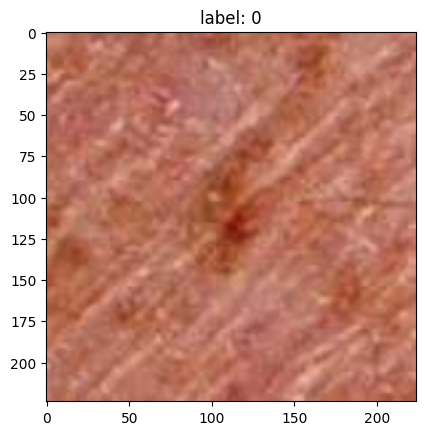

In [10]:
# 画像を1枚だけ表示
isic_id = "ISIC_0015670"
image, label = get_image_and_label(h5py.File(f"{base_path}/{train_image_hdf5}", "r"), isic_id)

plt.imshow(image)
plt.title(f"label: {label}")
plt.show()

image shape: (4, 224, 224, 3)
image type: float64
image max: 1.0, min: 0.0
label shape: (4,)


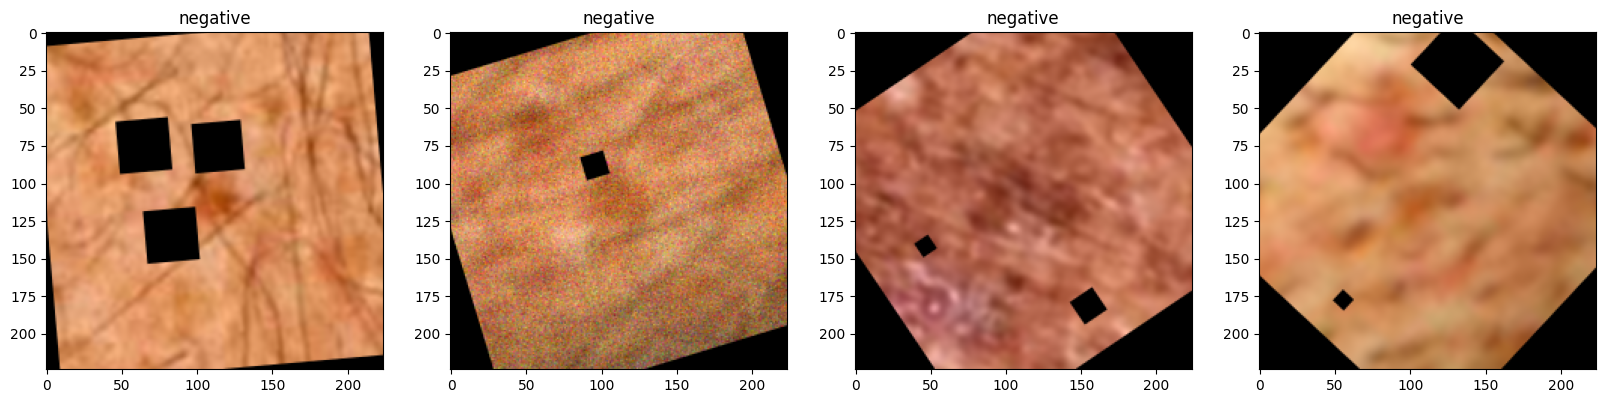

In [11]:
show_img_size = 4
# 画像を取得して表示
plt.figure(figsize=(20, 5))
for images, labels in generator(df_train_dataset, batch_size=show_img_size, mode="train", is_shuffle=False,
                                is_one_epoch=True, is_augmentation=True, is_train=False):
    # 画像の情報を表示
    print(f"image shape: {images.shape}")
    print(f'image type: {images.dtype}')
    print(f"image max: {images.max()}, min: {images.min()}")
    print(f"label shape: {labels.shape}")

    for i, (image, label) in enumerate(zip(images, labels)):
        # 最小値を0, 最大値を1にする
        
        plot_size = min(show_img_size, len(images))
        plt.subplot(1, plot_size, i + 1)
        plt.imshow(image)
        if label == 1:
            plt.title(f"positive")
        else:
            plt.title("negative")
    plt.show()

    break

### モデルの定義

In [12]:
def comp_score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str, min_tpr: float = 0.80):
    v_gt = abs(np.asarray(solution.values) - 1)
    v_pred = np.array([1.0 - x for x in submission.values])
    max_fpr = abs(1 - min_tpr)
    partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
    # change scale from [0.5, 1.0] to [0.5 * max_fpr**2, max_fpr]
    # https://math.stackexchange.com/questions/914823/shift-numbers-into-a-different-range
    partial_auc = 0.5 * max_fpr ** 2 + (max_fpr - 0.5 * max_fpr ** 2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)
    return partial_auc


def auroc(y_true, y_pred, min_fpr=0.8):
    v_gt = tf.abs(y_true - 1)
    v_pr = tf.abs(y_pred - 1)
    partial_auc_scaled = tf.py_function(comp_score, [v_gt, v_pr], tf.float64)
    partial_auc = 0.5 * min_fpr ** 2 + (min_fpr - 0.5 * min_fpr ** 2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)
    return partial_auc


class AUCROCMetric(tf.keras.metrics.Metric):
    def __init__(self, name='aucroc', **kwargs):
        super(AUCROCMetric, self).__init__(name=name, **kwargs)
        self.auc_metric = tf.keras.metrics.AUC()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.auc_metric.update_state(y_true, y_pred, sample_weight)

    def result(self):
        return self.auc_metric.result()

    def reset_states(self):
        self.auc_metric.reset_states()

def binary_crossentropy_balance(target, output):
    # target を output の型にキャスト
    target = tf.dtypes.cast(target, output.dtype)
    epsilon_ = constant_op.constant(0.00001, output.dtype)

    # nan を防ぐためにクリップ
    output = clip_ops.clip_by_value(output, epsilon_, 0.99999)

    # 交差エントロピーの計算
    bce = target * math_ops.log(output + epsilon_) * 1.0
    bce += (1.0 - target) * math_ops.log(1.0 - output + epsilon_)

    bce_sum = -K.sum(bce, axis=-1)
    return bce_sum

class GeM(tf.keras.layers.Layer):
    def __init__(self, p=3.0, eps=1e-6, **kwargs):
        super(GeM, self).__init__(**kwargs)
        self.p = tf.Variable(initial_value=p, trainable=True, dtype=tf.float32)
        self.eps = eps

    def call(self, inputs):
        return tf.reduce_mean(tf.pow(tf.clip_by_value(inputs, self.eps, tf.reduce_max(inputs)), self.p), axis=[1, 2])

def create_model(model_name='EfficientNetB0'):
    # カスタム入力層
    input_shape = (CONFIG["IMAGE_HEIGHT"], CONFIG["IMAGE_WIDTH"], CONFIG["IMAGE_CHANNEL"])
    inputs = Input(shape=input_shape)

    x = inputs

    # DenseNet201
    base_model = tf.keras.applications.EfficientNetB0(
        include_top=False,
        weights="imagenet",
        input_tensor=x,
        input_shape=input_shape,
        pooling=None,
    )

    # ベースモデルの出力
    x = base_model.output
    x = GeM()(x)
    x = Dense(1, activation='sigmoid')(x)

    # モデルの作成
    model = Model(inputs=inputs, outputs=x, name=model_name)

    # optimizer : Adam
    opt = tf.keras.optimizers.AdamW(learning_rate=CONFIG["LR"])

    # モデルのコンパイル
    model.compile(optimizer=opt, loss=binary_crossentropy_balance, metrics=['accuracy'])

    return model

In [13]:
model = create_model()
# モデルの概要を表示
# model.summary()

In [14]:
from keras.src.callbacks import EarlyStopping


class CustomCheckpoint(Callback):
    def __init__(self, filepath):
        super(CustomCheckpoint, self).__init__()
        self.filepath = filepath
        self.best_val_accuracy = 1.0

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_log_loss_metrics = logs.get('val_loss')

        if val_log_loss_metrics is not None and val_log_loss_metrics < self.best_val_accuracy and val_log_loss_metrics < 0.8:
            self.best_val_accuracy = val_log_loss_metrics
            filepath = f'{self.filepath}.keras'
            self.model.save(filepath, overwrite=True)
            print(f'Saved model to {filepath} with validation accuracy: {val_log_loss_metrics:.4f}')


# カスタムチェックポイントのコールバックを作成
custom_checkpoint = CustomCheckpoint(filepath='model_dense')
Ecall = EarlyStopping(monitor='val_loss', patience=CONFIG["PATIENCE"], restore_best_weights=True)

In [15]:
train_steps = int(np.ceil(len(df_train_dataset) / CONFIG["BATCH_SIZE"]))
val_steps = int(np.ceil(len(df_val_dataset) / CONFIG["VAL_BATCH_SIZE"]))

history = model.fit(
    generator(df_train_dataset, is_augmentation=True, is_shuffle=True, is_train=True, is_multi_threading=True),
    steps_per_epoch=train_steps,
    epochs=1,
    validation_data=generator(df_val_dataset, is_augmentation=False, is_shuffle=False, is_train=False, is_multi_threading=True),
    validation_steps=val_steps,
    callbacks=[custom_checkpoint, Ecall]
)

2024-08-07 23:42:52.916715: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 216s/step - accuracy: 0.6323 - loss: 1.9764  Saved model to model_dense.keras with validation accuracy: 0.6862
233/233 ━━━━━━━━━━━━━━━━━━━━ 54956s 236s/step - accuracy: 0.6324 - loss: 1.9734 - val_accuracy: 0.9490 - val_loss: 0.6862


In [ ]:
# モデルを読み込み
model = tf.keras.models.load_model('model_dense.keras', custom_objects={
    'GeM': GeM,
    'binary_crossentropy_balance': binary_crossentropy_balance,
})

In [ ]:
# テストデータの予測
y_pred = model.predict(
    generator(df_test_dataset, 
              is_augmentation=False,
              is_shuffle=False, 
              is_one_epoch=True,
              is_train=False,
              batch_size=1,
              ),
    steps=len(df_test_dataset)
)

In [ ]:
y_pred

In [ ]:
# スコアの計算
score = comp_score(df_test_dataset[["target"]], pd.DataFrame(y_pred, columns=["prediction"]), "")
print(f"score: {score}")

In [ ]:
# それぞれの列の型を調べる
print(submission.dtypes)
print(solution.dtypes)

In [ ]:
def comp_score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str, min_tpr: float=0.80):
    v_gt = abs(np.asarray(solution.values)-1)
    v_pred = np.array([1.0 - x for x in submission.values])
    max_fpr = abs(1-min_tpr)
    partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
    # change scale from [0.5, 1.0] to [0.5 * max_fpr**2, max_fpr]
    # https://math.stackexchange.com/questions/914823/shift-numbers-into-a-different-range
    partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)
    return partial_auc

In [ ]:
# スコアを計算
score = comp_score(solution["target"], submission["target"], "")
print(f"Score: {score:.4f}")

In [ ]:
# accuracy を計算 (0.5 以上の場合は 1, それ以外は 0)
submission_binary = submission.copy()
submission_binary["target"] = (submission["target"] > 0.5).astype(int)
solution["target"] = solution["target"].astype(int)
accuracy = (submission["target"].round() == solution["target"]).mean()
print(f"Accuracy: {accuracy:.4f}")

In [ ]:
# 結果をいくつか比較
print(submission.head())
print(solution.head())